<a href="https://colab.research.google.com/github/carlosheadst/Identifica-o-Glaucoma-RIM-ONE-r3/blob/main/U_Net_67.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

## Pré-Processamento

In [ ]:
def load_images_from_directory(image_dir, target_size=(256, 256), color_mode="grayscale"):
    image_list = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                img_path = os.path.join(root, file)
                img = image.load_img(img_path, target_size=target_size, color_mode=color_mode)
                img_array = image.img_to_array(img)
                img_array = img_array / 255.0
                image_list.append(img_array)
    return np.array(image_list)

def load_combined_masks_from_directory(mask_dir, target_size=(256, 256)):
    combined_mask_list = []
    for root, _, files in os.walk(mask_dir):
        file_map = {}
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                base_name = file.split('-Cup-Avg')[0].split('-Disc-Avg')[0]
                file_map.setdefault(base_name, []).append(file)

        for base_name, mask_files in file_map.items():
            cup_file = [file for file in mask_files if "Cup" in file][0]
            disc_file = [file for file in mask_files if "Disc" in file][0]

            cup_path = os.path.join(root, cup_file)
            disc_path = os.path.join(root, disc_file)

            cup_img = image.load_img(cup_path, target_size=target_size, color_mode="grayscale")
            disc_img = image.load_img(disc_path, target_size=target_size, color_mode="grayscale")

            cup_array = image.img_to_array(cup_img) / 255.0
            disc_array = image.img_to_array(disc_img) / 255.0

            combined_mask = np.maximum(disc_array, cup_array * 2)
            combined_mask_list.append(combined_mask)

    return np.array(combined_mask_list)

In [ ]:
dataset_path = "/content/drive/MyDrive/RIM-ONE r3"

In [ ]:
glaucoma_images = load_images_from_directory(os.path.join(dataset_path, "Glaucoma and suspects", "Stereo Images"))
healthy_images = load_images_from_directory(os.path.join(dataset_path, "Healthy", "Stereo Images"))

In [ ]:
glaucoma_masks = load_combined_masks_from_directory(os.path.join(dataset_path, "Glaucoma and suspects", "masks"))
healthy_masks = load_combined_masks_from_directory(os.path.join(dataset_path, "Healthy", "masks"))

In [ ]:
all_images = np.concatenate((glaucoma_images, healthy_images), axis=0)
all_masks = np.concatenate((glaucoma_masks, healthy_masks), axis=0)
all_labels = np.concatenate((np.ones(len(glaucoma_images)), np.zeros(len(healthy_images))), axis=0)

In [ ]:
print("Dimensões dos arrays:")
print("all_images:", all_images.shape)
print("all_masks:", all_masks.shape)
print("all_labels:", all_labels.shape)

Dimensões dos arrays:
all_images: (159, 256, 256, 1)
all_masks: (159, 256, 256, 1)
all_labels: (159,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(all_images, all_masks, test_size=0.2, random_state=42, stratify=all_labels)

## Data Augmentation

In [ ]:
def create_datagen():
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return datagen

def train_generator(X_train, y_train, datagen, batch_size):
    seed = 42
    image_generator = datagen.flow(X_train, seed=seed, batch_size=batch_size, shuffle=True)
    mask_generator = datagen.flow(y_train, seed=seed, batch_size=batch_size, shuffle=True)
    while True:
        yield (next(image_generator), next(mask_generator))

In [ ]:
batch_size = 16
datagen = create_datagen()
training_generator = train_generator(X_train, y_train, datagen, batch_size)

## Definição Arquitetura U-NET

In [ ]:
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, concat_tensor])

    x = conv_block(x, num_filters)
    return x

def unet_model(input_shape, num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # Bridge
    bridge = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(bridge, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## Criando o modelo

In [ ]:
# Crie o modelo U-Net
input_shape = (256, 256, 1)
model = unet_model(input_shape)

In [ ]:
# Compile o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Parâmetros de treinamento
epochs = 100
# Para o modelo se não houver melhora no erro por 10 épocas consecutivas
early_stopping = EarlyStopping(patience=10, verbose=1)
# Salva durante o treinamento o melhor modelo no arquivo glaucoma_model.h5
model_checkpoint = ModelCheckpoint("glaucoma_model.h5", save_best_only=True, verbose=1)

In [ ]:
# # Modelo antes do data augmentation
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(X_val, y_val),
#     shuffle=True
# )

# Modelo depois do data augmentation
history = model.fit(training_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.7770
Epoch 1: val_loss improved from inf to 2.80263, saving model to glaucoma_model.h5
7/7 [==============================] - 22s 1s/step - loss: 0.8189 - accuracy: 0.7770 - val_loss: 2.8026 - val_accuracy: 0.0213
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.9834
Epoch 2: val_loss did not improve from 2.80263
7/7 [==============================] - 6s 848ms/step - loss: 0.3074 - accuracy: 0.9834 - val_loss: 110.7133 - val_accuracy: 4.1866e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9945
Epoch 3: val_loss did not improve from 2.80263
7/7 [==============================] - 6s 848ms/step - loss: 0.2018 - accuracy: 0.9945 - val_loss: 267.4315 - val_accuracy: 0.0107
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9960
Epoch 4: val_loss did not improve from 2.80263
7/7 [=======

In [ ]:
def plot_history(history):
    # Extrair informações do histórico
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Gráfico de acurácia
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Acurácia - treinamento')
    plt.plot(epochs, val_acc, 'b', label='Acurácia - validação')
    plt.title('Acurácia no treinamento e na validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico de perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Perda - treinamento')
    plt.plot(epochs, val_loss, 'b', label='Perda - validação')
    plt.title('Perda no treinamento e na validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

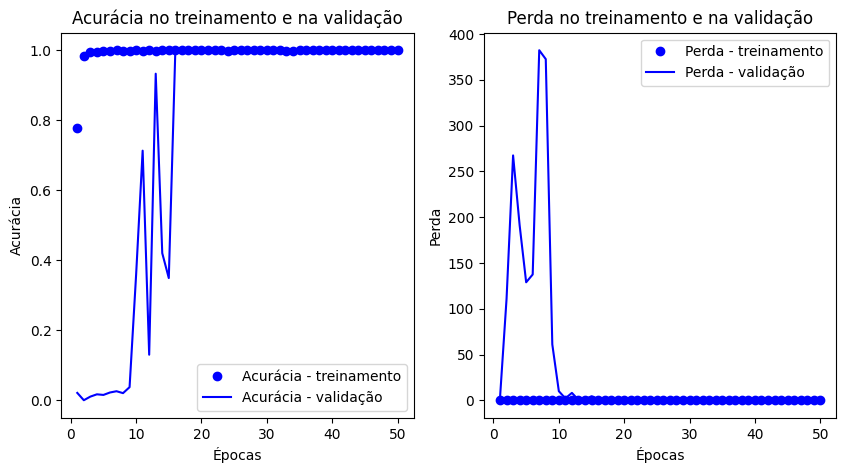

In [ ]:
plot_history(history)

In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
# Carregando modelo salvo
model = load_model("glaucoma_model.h5")

In [ ]:
# Carregar e pré-processar a nova imagem
new_image_path = '/content/drive/MyDrive/RIM-ONE r3/Glaucoma and suspects/Stereo Images/G-1-L.jpg'
# new_image_path = '/content/drive/MyDrive/RIM-ONE r3/Healthy/Stereo Images/N-1-L.jpg'
new_image = preprocess_image(new_image_path)

In [ ]:
# Fazer a predição usando o modelo treinado
prediction = model.predict(new_image)

# Identificar as regiões do disco óptico e da escavação
predicted_mask = np.argmax(prediction[0], axis=-1)
optic_disc_region = predicted_mask == 1
cup_region = predicted_mask == 2

# Calcular a razão entre a área da escavação e a área do disco óptico
cup_to_disc_ratio = np.sum(cup_region) / np.sum(optic_disc_region)

print("Razão entre a área da escavação e a área do disco óptico: {:.2f}".format(cup_to_disc_ratio))

1/1 [==============================] - 0s 32ms/step
Razão entre a área da escavação e a área do disco óptico: nan


<ipython-input-108-53df8fc87f4a>:10: RuntimeWarning: invalid value encountered in long_scalars
  cup_to_disc_ratio = np.sum(cup_region) / np.sum(optic_disc_region)


In [ ]:
def load_test_images(test_set_path):
    X_test, y_test = [], []
    for label, folder in enumerate(['normal', 'glaucoma']):
        folder_path = os.path.join(test_set_path, folder)
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img_array = preprocess_image(img_path)
            X_test.append(img_array)
            y_test.append(label)
    return np.vstack(X_test), np.array(y_test)

In [ ]:
# Carregar e pré-processar as imagens de teste
test_set_path = '/content/drive/MyDrive/test_set'
X_test, y_test = load_test_images(test_set_path)

In [ ]:
# Carregando modelo salvo
model = load_model("glaucoma_model.h5")

# Fazer previsões e calcular as probabilidades de glaucoma
predictions = model.predict(X_test)
glaucoma_probabilities = np.mean(predictions[:, :, :, 1], axis=(1, 2))

6/6 [==============================] - 3s 475ms/step


In [ ]:
# Definir um limite de probabilidade para classificar as imagens como glaucoma ou normal
threshold = 0.5
y_pred = (glaucoma_probabilities > threshold).astype(int)

# Calcular métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Acurácia: {:.2%}".format(accuracy))
print("Sensibilidade: {:.2%}".format(sensitivity))
print("Especificidade: {:.2%}".format(specificity))

Acurácia: 67.82%
Sensibilidade: 0.00%
Especificidade: 100.00%
